## Install Dependencies


### torch, torchvision

In [1]:
# install torch and torchvision
!pip3 install torch torchvision torchaudio torchtext --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


### pytorch3d

In [2]:
import os
import torch

try:
    import pytorch3d
except ModuleNotFoundError:
    !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
    !tar xzf 1.10.0.tar.gz
    os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
    !pip install git+https://github.com/facebookresearch/pytorch3d.git

In [3]:
import pytorch3d
pytorch3d.__version__

'0.7.1'

### SMPL / Meshes

In [4]:
!pip install smplpytorch
!pip install chumpy
!pip install trimesh

### CLIP

In [5]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\avern\appdata\local\temp\pip-req-build-2htm418v
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\avern\AppData\Local\Temp\pip-req-build-2htm418v'


## GPU

In [6]:
import torch

torch.cuda.is_available()

False

In [7]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


In [8]:
# GPU or CPU
gpu, cpu = None, None
if torch.cuda.is_available():
    gpu = torch.device("cuda:0")
    torch.cuda.set_device(gpu)
else:
    cpu = torch.device("cpu")
dev = gpu if gpu is not None else cpu
dev

device(type='cpu')

## Setup

### Codebase Loading

In [9]:
!rm -rf project #remove if it already exists 
!git clone https://github.com/B4Farouk/smpl-dr-clip project
!rm -rf sample_data

'rm' is not recognized as an internal or external command,
operable program or batch file.
fatal: destination path 'project' already exists and is not an empty directory.
'rm' is not recognized as an internal or external command,
operable program or batch file.


### Local Imports 

In [10]:
from project.aux_functions import *

from project.smpl import SMPLwrapper, mesh_from
from project.textures import TexturesFactory
from project.rendering import CamerasFactory, Renderer
from project.clipwrapper import CLIPwrapper

from project.optimization import OptimEnv, init_weights,init_random_weights
from project.model import compose, SimpledCLIPContext

import trimesh

import clip

%load_ext autoreload
%autoreload 2

c:\Users\avern\AppData\Local\Programs\Python\Python39\lib\site-packages\smplpytorch\pytorch\smpl_layer.py:41: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:178.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


## Test: SMPL and Rendering

In [11]:
# initalize a textures factory
txfactory = TexturesFactory(device=dev)
colored_reference_SMPL = trimesh.load("project/SMPL_female_with_colors.obj", process=False)
# use the texture factory to create a texture generator: a function that takes faces and creates a texture
def texture_generator(verts,faces):
  return txfactory.from_image(colored_reference_SMPL ,verts, faces)
# pose and shape initalization
pose_vect = torch.zeros((1, 72), device=dev) # theta, used in optimization
shape_vect = torch.ones((1, 10), device=dev) # beta, not used in optimization
# create the smpl model
smpl_model = SMPLwrapper(model=None, batchsize=5, txmapping=texture_generator, device=dev) #model=None uses the default model
# create the mesh
meshes = smpl_model.meshes(theta=pose_vect, beta=shape_vect)

In [12]:
# create a cameras factory
camsfactory = CamerasFactory(device=dev)
# cameras' spherical coordinates
radiuses = [2]*5
azimuths = (0, 45, 135, -45, -135)
elevations = [10]*5
coords = (radiuses, azimuths, elevations)
# create cameras using cameras factory
cameras = camsfactory.fov_persp_scs(coords=coords, fov=60, frustrum_depth=(1, 100))
# create a renderer
renderer = Renderer(device=dev, cameras=cameras)
# render the textured meshes generated by SMPL
test_imgs_t = renderer.render(meshes)
# shape of the rendered images
test_imgs_t.shape

torch.Size([5, 244, 244, 4])

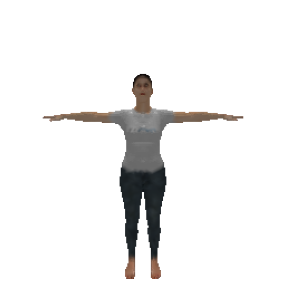

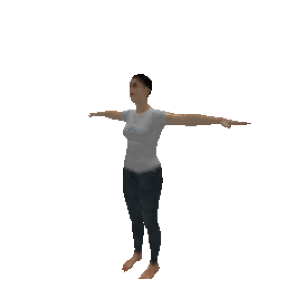

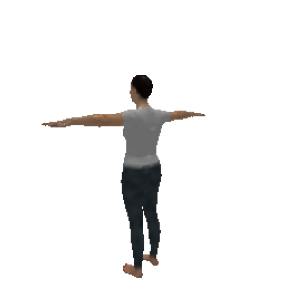

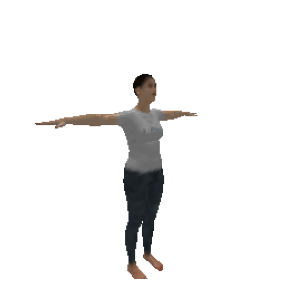

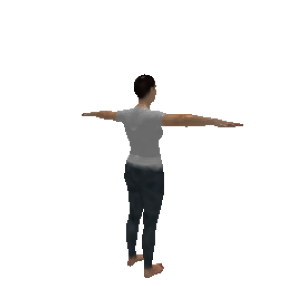

In [13]:
# a quick visualization of the rendered mesh
for test_img_t in test_imgs_t:
  plot_image_t(test_img_t)

## Test: CLIP

In [14]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [15]:
clip_model = CLIPwrapper(model_name="ViT-B/32", device=dev)

#### Test: Our Implementation of CLIP Image Preprocessing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


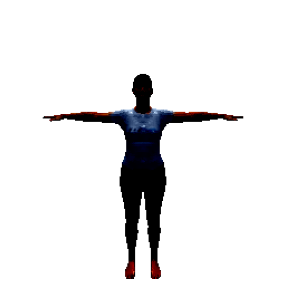

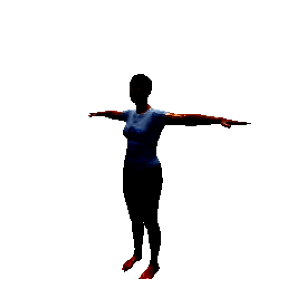

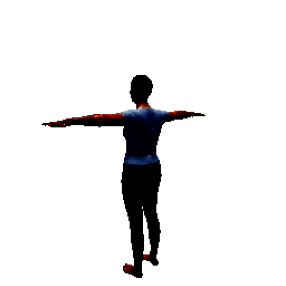

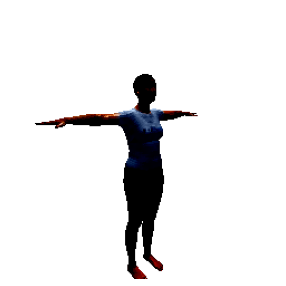

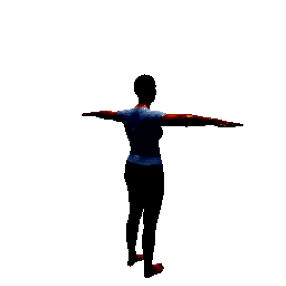

In [16]:
proc_test_imgs_t = torch.permute(clip_model.proc_imgs(test_imgs_t), (0, 2, 3, 1)) # N 3 W H => N W H 3 so 0 1 2 3 => 0 2 3 1
# a quick visualization of the processed images (matplotlib automatically clamps the pixels)
for proc_test_img_t in proc_test_imgs_t:
  plot_image_t(proc_test_img_t)

#### Test: How much does CLIP recognize our mesh and the position it is in ?

In [17]:
# a prompt describing the previous image
pmt_emb = clip_model.pmt_emb("""a white human wearing a light grey T-shirt and blue pants, standing up on her straight feet. She is looking upfront with both hands apart and at the shoulder level.""")
imgs_embs = clip_model.imgs_embs(test_imgs_t)

In [18]:
imgs_embs.shape, pmt_emb.shape

(torch.Size([5, 512]), torch.Size([1, 512]))

In [19]:
img_emb = imgs_embs.mean(axis=0, keepdims=True)
float(cos_dist(img_emb, pmt_emb))

0.7286595702171326

In [20]:
cosine_distances = torch.Tensor([cos_dist(img_emb.unsqueeze(0), pmt_emb) for img_emb in imgs_embs])
cosine_distances

tensor([0.7209, 0.7082, 0.7597, 0.7283, 0.7498])

In [21]:
float(cosine_distances.mean())

0.7333946228027344

## MODELS


In [22]:
# create a model factory
model_context = SimpledCLIPContext(smpl_model, renderer, clip_model) 
MODELS = {
    "P1": model_context.create(
        prompt="""a white human wearing a light grey T-shirt and blue pants, standing up on her straight feet. She is looking upfront with both hands down.""")
    }

### Test: Does the model work ?

In [25]:
pose, shape = init_weights(dev)
test_imgs_embs, test_pmt_emb = MODELS["P1"](pose, shape)
test_imgs_embs.shape, test_pmt_emb.shape

(torch.Size([5, 512]), torch.Size([1, 512]))

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:>)

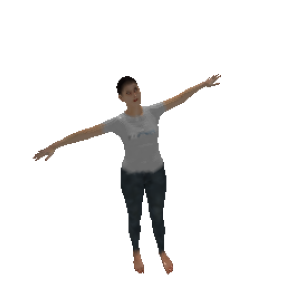

In [28]:
pose, shape = init_random_weights(dev)
def model(pose, shape):
        return renderer.render(smpl_model.meshes(pose, shape))
image=model(pose,shape)
plot_image_t(image[0].squeeze())

### Optimization

In [ ]:
# optimization config
optim_config = {
    "lr": 1e-3,
    "betas": (0.9, 0.999),

    "loss_mode": "average-loss-on-embeddings",

    "sch_factor": 0.5,
    "sch_patience": 5,
    "sch_threshold": 1e-3,
    "sch_cooldown": 50,
    "sch_verbose": True
}

# tracker config
tracker_config = {
    "loss": {"interleaving": 10}, 
    "pose": {"interleaving": 100},
    "shape": {"interleaving": 100}
}


def run_optimization(model, n_passes=1000, activate_lr_sch=False):
  # weights used in optimization
  pose, shape = init_weights(device=dev) 
  # optimize with respect to the pose only
  optimenv = OptimEnv(model=model, weights=[pose], activate_lr_sch=activate_lr_sch, config=optim_config) 
  result = optimenv.optimize(pose=pose, shape=shape, n_passes=n_passes, tracker_config=tracker_config)
  return result

def intermediate_views(result, coords):
  smpl_model = SMPLwrapper(model=None, batchsize=1, txmapping=texture_generator, device=dev) #model=None uses the default model
  camera = camsfactory.fov_persp_scs(coords=coords, fov=60, frustrum_depth=(1, 100))
  renderer = Renderer(cameras=camera, device=dev)
  
  pose_shape = zip(result["tracked"]["poses"]["pose"], result["tracked"]["shapes"]["shape"])
  for pose, shape in pose_shape:
    pose, shape = pose.to(dev), shape.to(dev)
    mesh = smpl_model.meshes(theta=pose, beta=shape)
    image = renderer.render(mesh)
    plot_image_t(image.squeeze())

### Results

In [ ]:
p1_result = run_optimization(model=MODELS["P1"], n_passes=1000, activate_lr_sch=False)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\avern\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\avern\AppData\Local\Temp\ipykernel_9540\2290772028.py", line 1, in <cell line: 1>
    p1_result = run_optimization(model=MODELS["P1"], n_passes=1000, activate_lr_sch=False)
  File "C:\Users\avern\AppData\Local\Temp\ipykernel_9540\2367239664.py", line 28, in run_optimization
    result = optimenv.optimize(pose=pose, shape=shape, n_passes=n_passes, tracker_config=tracker_config)
  File "c:\Users\avern\Documents\GitHub\smpl-dr-cli\project\optimization.py", line 112, in optimize
    loss = self.forward(pose, shape)
  File "c:\Users\avern\Documents\GitHub\smpl-dr-cli\project\optimization.py", line 72, in forward
    imgs_embs, pmt_emb = self.__model(pose, shape)
  File "c:\Users\avern\Documents\GitHub\smpl-dr-cli\project\model.py", line 26, in model
 

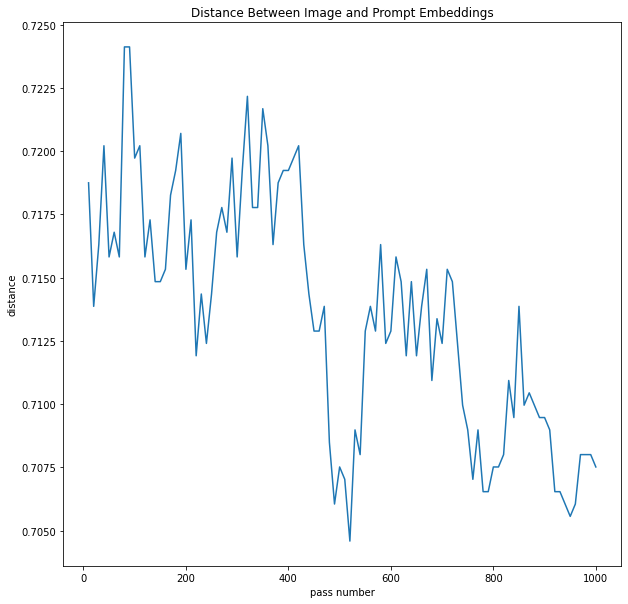

In [ ]:
plot_losses(p1_result["tracked"]["losses"])

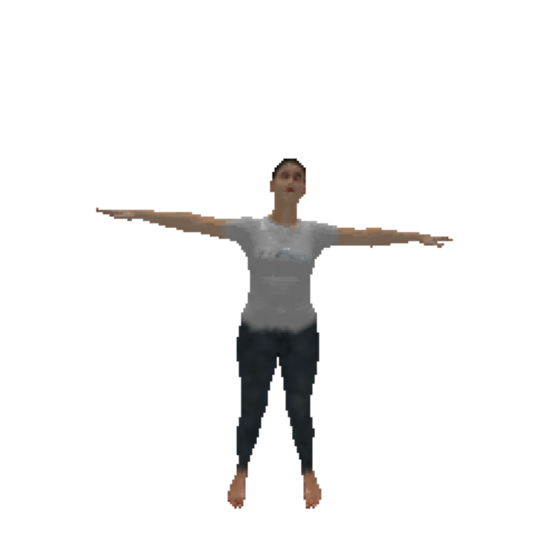

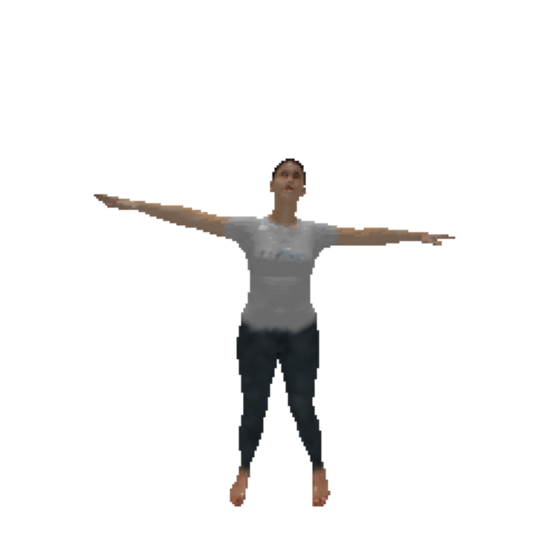

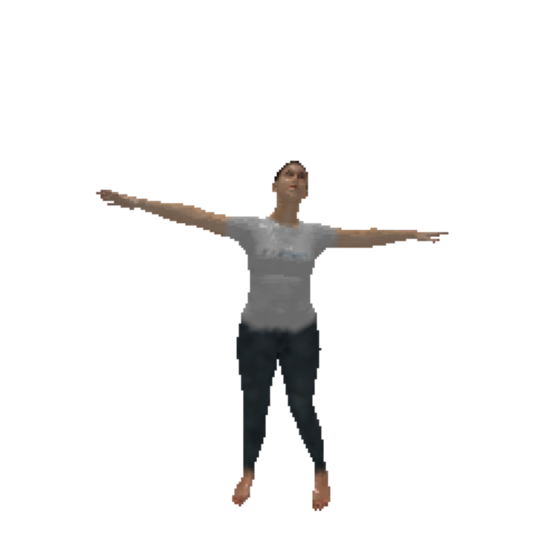

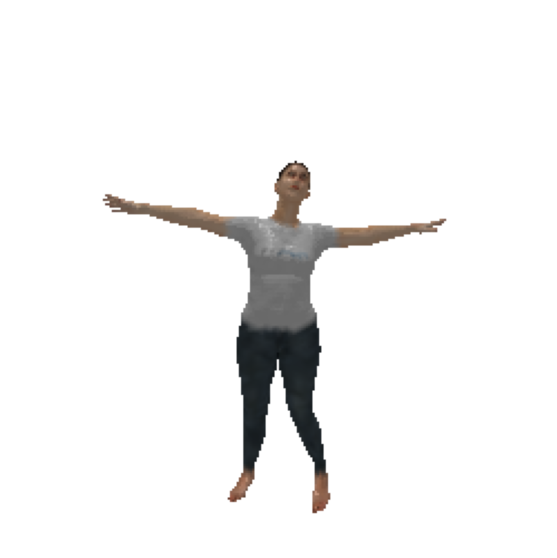

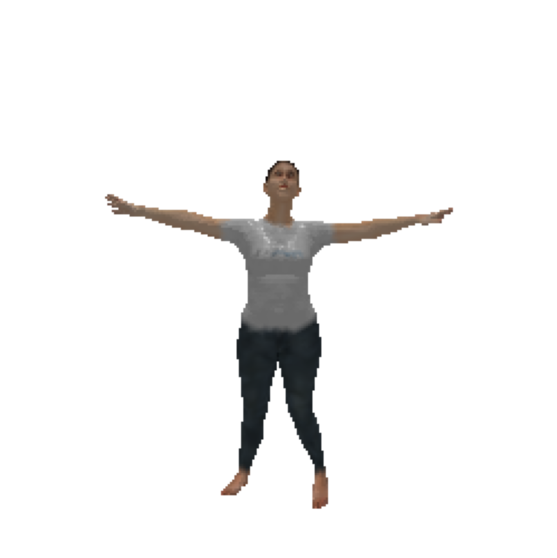

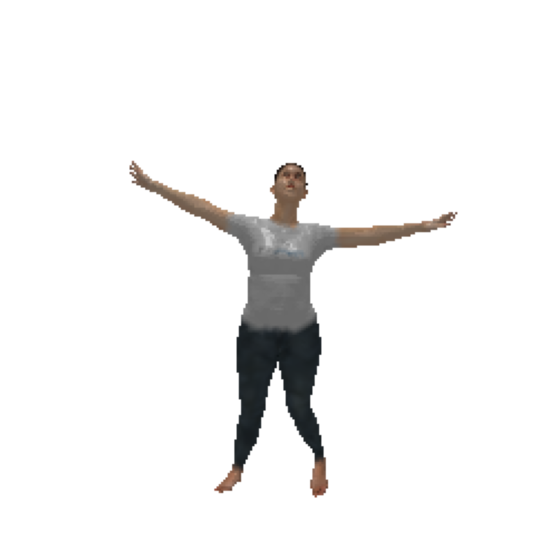

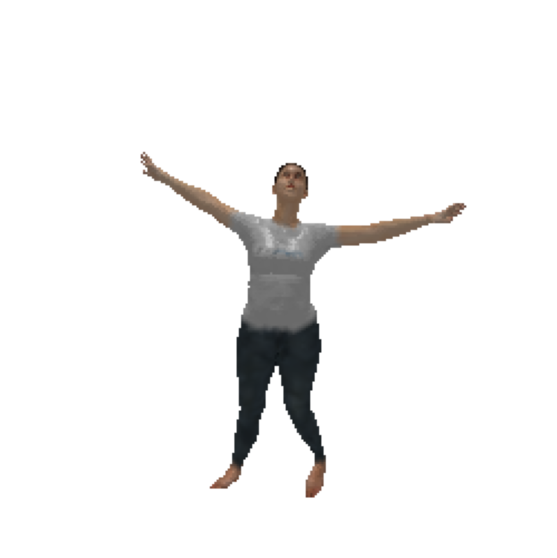

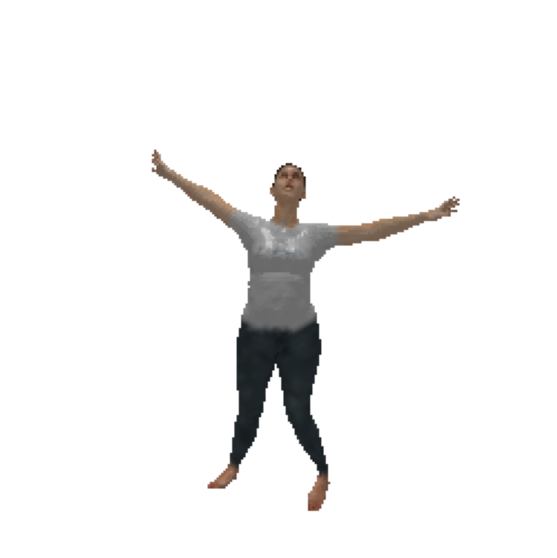

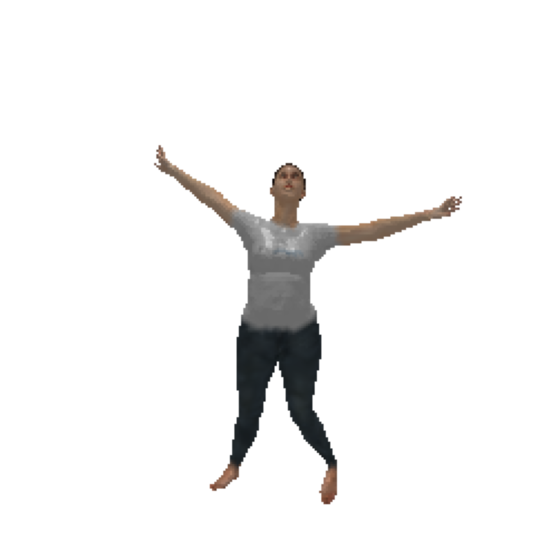

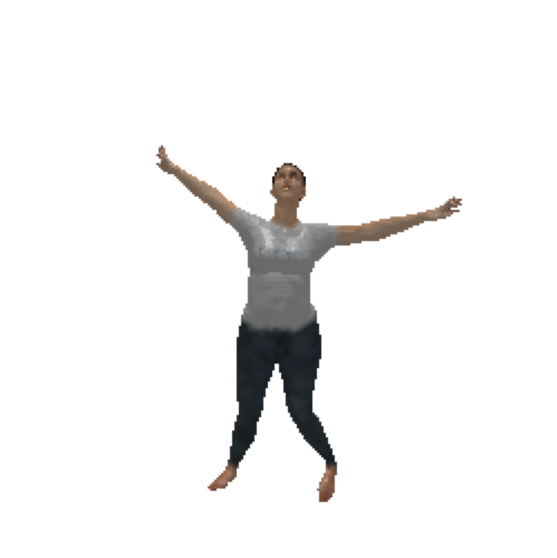

In [ ]:
intermediate_views(p1_result, coords=(2.25, 0, 10))

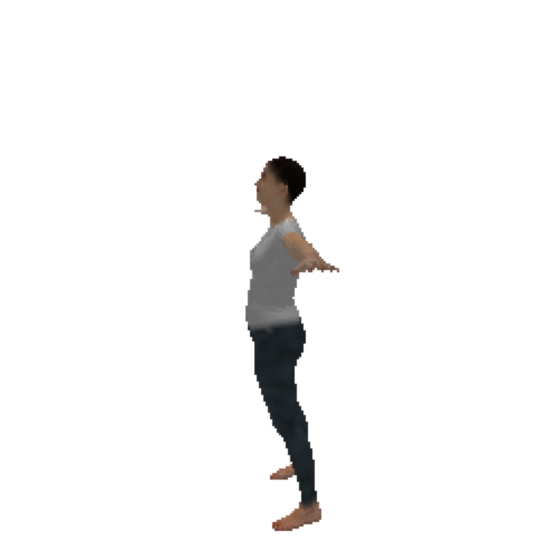

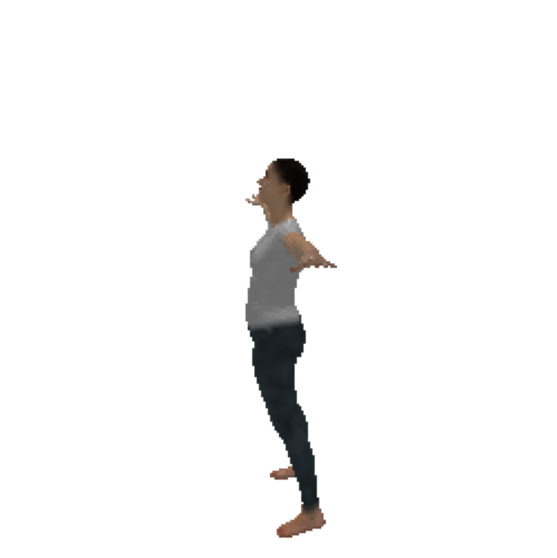

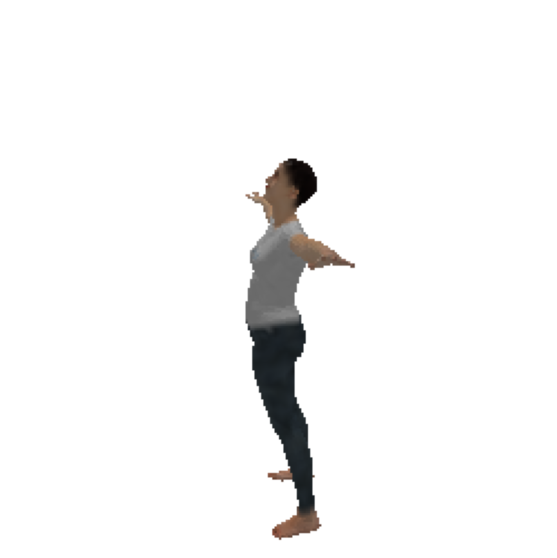

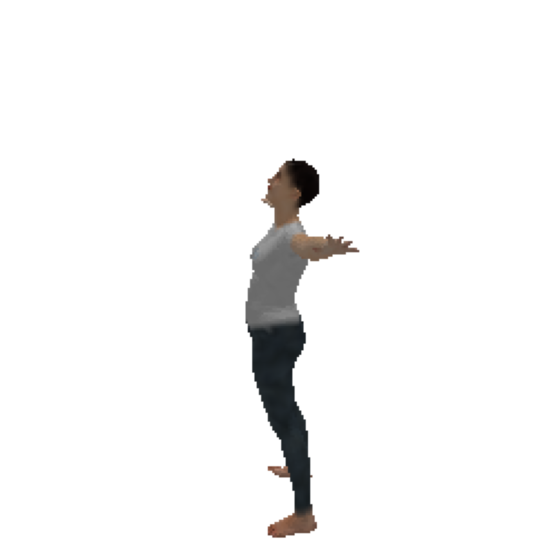

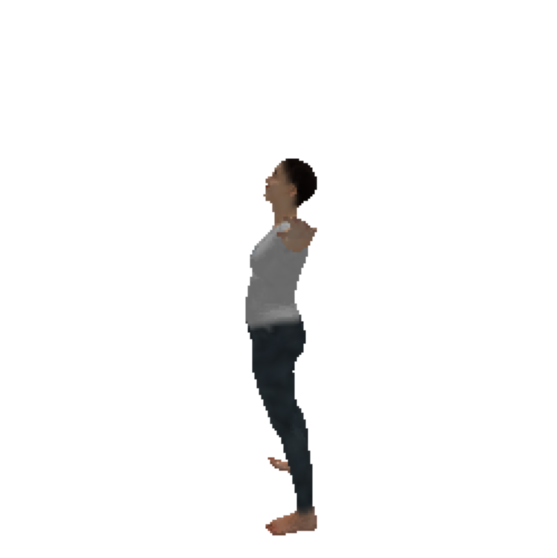

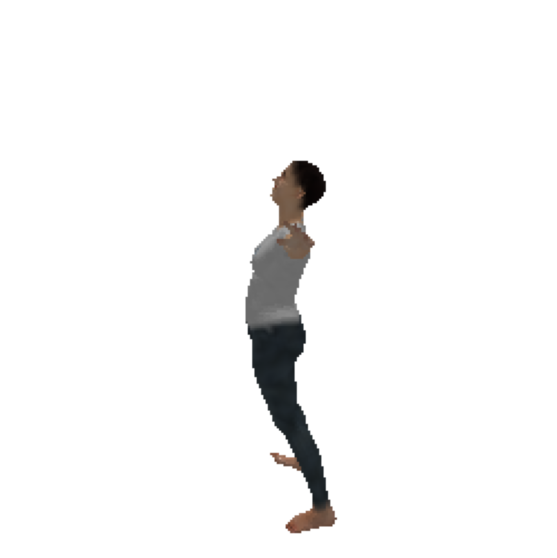

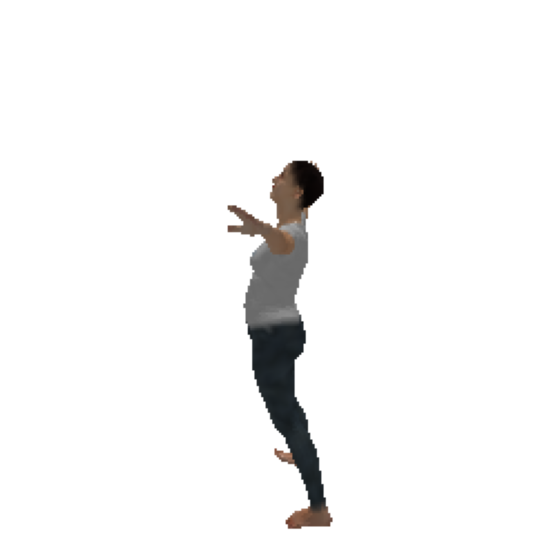

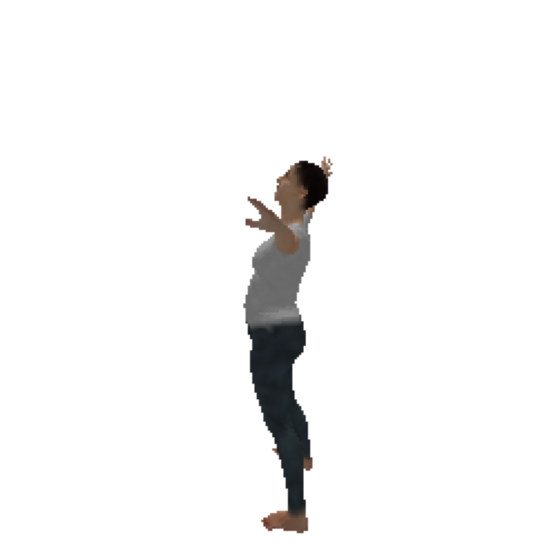

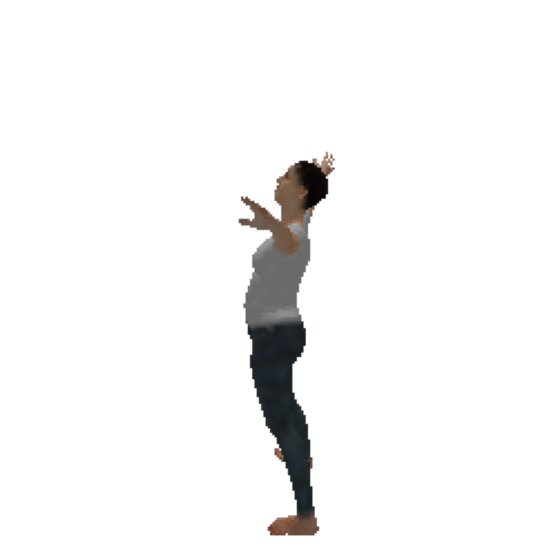

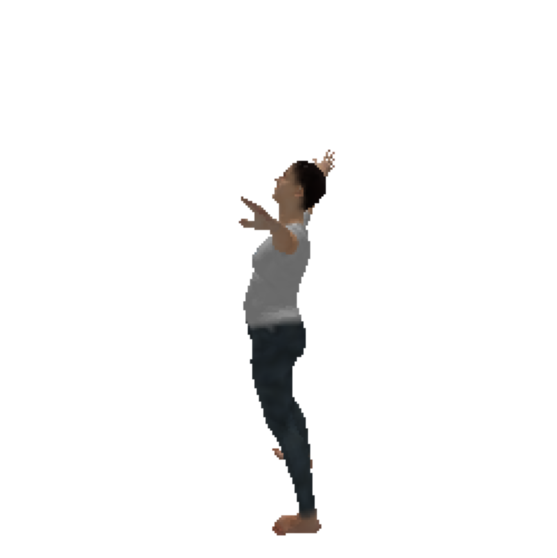

In [ ]:
intermediate_views(p1_result, coords=(2.25, 90, 10))

In [ ]:
p1_LRsch_result = run_optimization(MODELS["P1"], n_passes=1000, activate_lr_sch=True)

In [ ]:
plot_losses(result2["tracked"]["losses"])

In [ ]:
intermediate_views(result2, coords=(2.25, 0, 3))